# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.models import infer_signature

Grouping the model experiments under "Multiple Models Experiments" and runing ml flow autolog to autolog everything but not the model as we will do it manually to prevent thw warnings

In [4]:
mlflow.set_experiment("Multiple Models Experiment")
mlflow.autolog(log_models=False)

2025/05/16 09:39:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/05/16 09:39:43 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the installed version is 3.0.1. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/05/16 09:39:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


# Load Data

In [5]:
df = pd.read_csv("Data/diabetes_prediction_dataset_cleaned_imputed_outliers_and_smoking.csv")
X = df.drop("diabetes", axis=1)
y = df["diabetes"]
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,former,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# Define categorical & numerical columns


In [6]:
categorical_cols = ['gender', 'smoking_history']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Data preprocessing

In [7]:
#  convert categorical columns by one-hot encoding 
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
# this is smote that used to balance the dataset through oversampling
smote = SMOTE(random_state=42)


# Evaluation Function

In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n {model_name} Evaluation")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_proba):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()


# Models 

In [11]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            'classifier__C': [0.1, 1, 10],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 6],
            'classifier__learning_rate': [0.01, 0.1]
        }
    }
}

results = {}
best_models = {}

# Train and Evaluate Models


Training and Evaluating: Logistic Regression


2025/05/16 09:39:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/16 09:39:43 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/16 09:39:44 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/16 09:39:45 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/16 09:39:46 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model t

Cross-validated ROC-AUC scores: [0.96048831 0.96774166 0.96684694 0.96189061 0.96678663]
Mean ROC-AUC: 0.9648


2025/05/16 09:39:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/16 09:39:58 INFO mlflow.sklearn.utils: Logging the 5 best runs, one run will be omitted.
2025/05/16 09:39:58 WARNING mlflow.utils.autologging_utils: 

Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best ROC-AUC Score: 0.9648

 Logistic Regression Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     17330
           1       0.45      0.88      0.60      1693

    accuracy                           0.89     19023
   macro avg       0.72      0.89      0.77     19023
weighted avg       0.94      0.89      0.91     19023

ROC-AUC Score: 0.9647112665471242


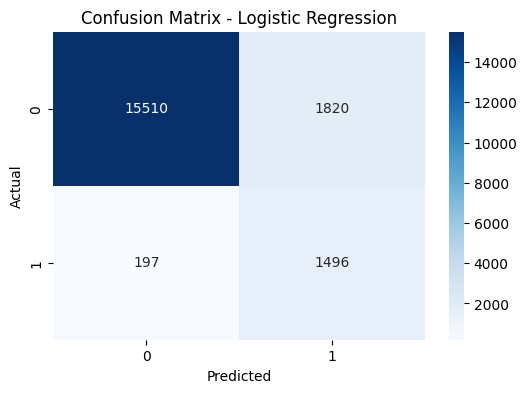

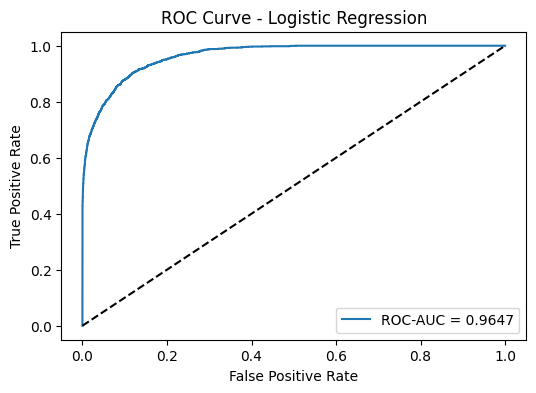

c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_


Training and Evaluating: Random Forest


2025/05/16 09:40:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/16 09:40:18 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/16 09:40:18 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/16 09:40:32 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/05/16 09:40:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/05/16 09:40:45 WARNING mlflow.sklearn: Training metri

Cross-validated ROC-AUC scores: [0.96866495 0.97448111 0.97353274 0.97062307 0.96980542]
Mean ROC-AUC: 0.9714


2025/05/16 09:41:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/16 09:44:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.
2025/05/16 09:44:23 WARNING mlflow.utils.autologging_utils: E

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC-AUC Score: 0.9760

 Random Forest Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     17330
           1       0.73      0.79      0.76      1693

    accuracy                           0.96     19023
   macro avg       0.85      0.88      0.87     19023
weighted avg       0.96      0.96      0.96     19023

ROC-AUC Score: 0.9764299316045943


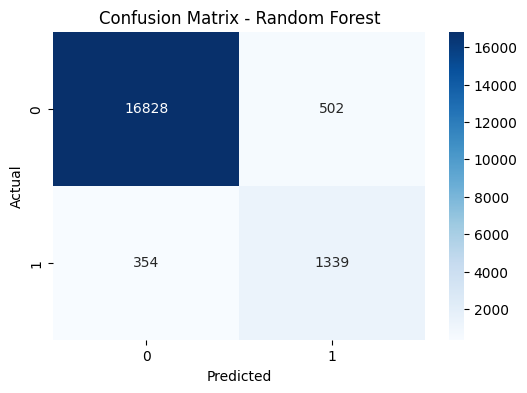

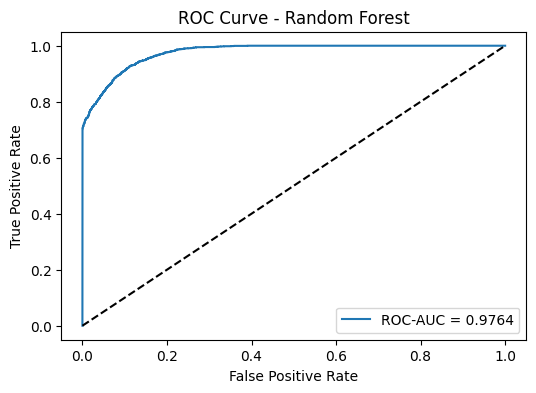

c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Random_Forest_Model' already exists. Creating a new version of this model...
Created version '2' of model 'Random_Forest_Model'.
2025/05/16 09:44:30 WARNING mlflow.sklearn: Training metrics will not be recorded because trainin


Training and Evaluating: XGBoost


c:\ProgramData\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:44:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/05/16 09:44:31 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
c:\ProgramData\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/05/16 09:44:32 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
c:\ProgramData\m

Cross-validated ROC-AUC scores: [0.97707522 0.97993675 0.98002512 0.97812742 0.97849384]
Mean ROC-AUC: 0.9787


2025/05/16 09:44:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
c:\ProgramData\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:44:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
Best ROC-AUC Score: 0.9799

 XGBoost Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17330
           1       0.89      0.76      0.82      1693

    accuracy                           0.97     19023
   macro avg       0.93      0.87      0.90     19023
weighted avg       0.97      0.97      0.97     19023

ROC-AUC Score: 0.9807645036467665


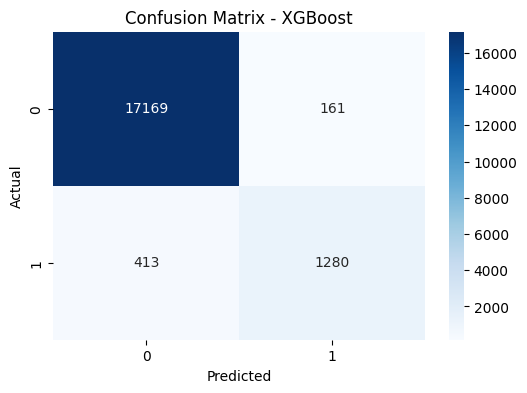

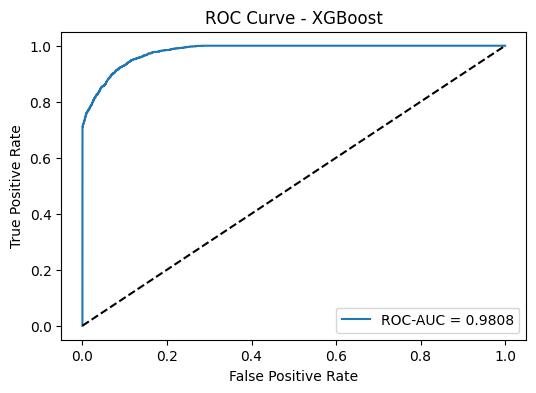

c:\ProgramData\miniconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'XGBoost_Model' already exists. Creating a new version of this model...
Created version '2' of model 'XGBoost_Model'.


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model_info in models.items():
    print(f"\nTraining and Evaluating: {name}")
    
    with mlflow.start_run(run_name=name):
        # Create pipeline with SMOTE
        pipeline = ImbPipeline(steps=[
            ('preprocessing', preprocessor),
            ('smote', smote),
            ('classifier', model_info["model"])
        ])
        
        # Cross-validation
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
        print(f"Cross-validated ROC-AUC scores: {scores}")
        print(f"Mean ROC-AUC: {np.mean(scores):.4f}")
        
        # Hyperparameter tuning
        grid_search = GridSearchCV(
            pipeline,
            param_grid=model_info["params"],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Best ROC-AUC Score: {grid_search.best_score_:.4f}")
        
        # Evaluate best model
        best_model = grid_search.best_estimator_
        evaluate_model(best_model, X_test, y_test, name)
        
        results[name] = grid_search.best_score_
        best_models[name] = best_model

        # Manually log model to suppress signature warning
        input_example = X_train[:5]
        signature = infer_signature(X_train, best_model.predict(X_train))

        mlflow.sklearn.log_model(
            sk_model=best_model,
            artifact_path="model",
            input_example=input_example,
            signature=signature,
            registered_model_name=f"{name.replace(' ', '_')}_Model"
        )


# Feature Importance

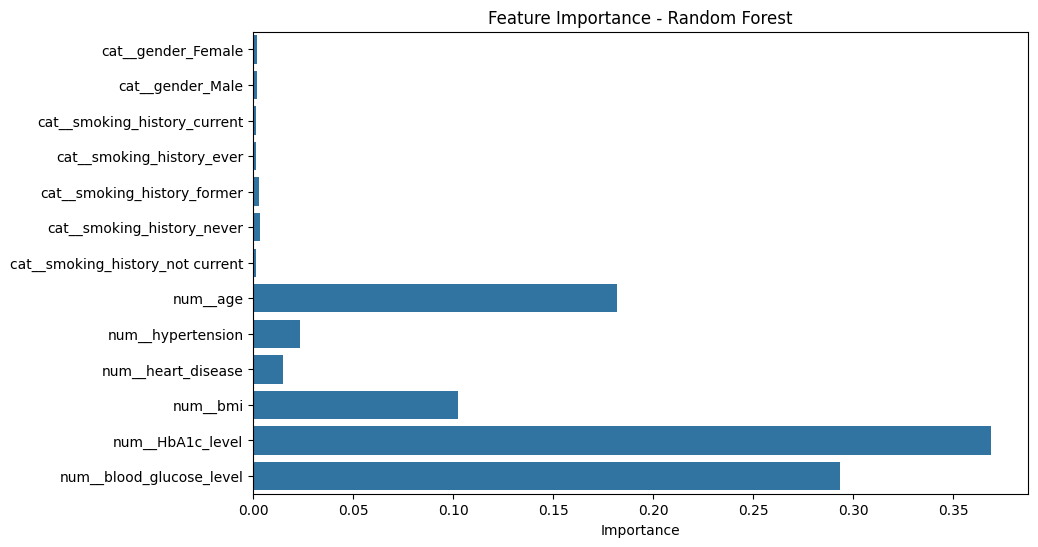

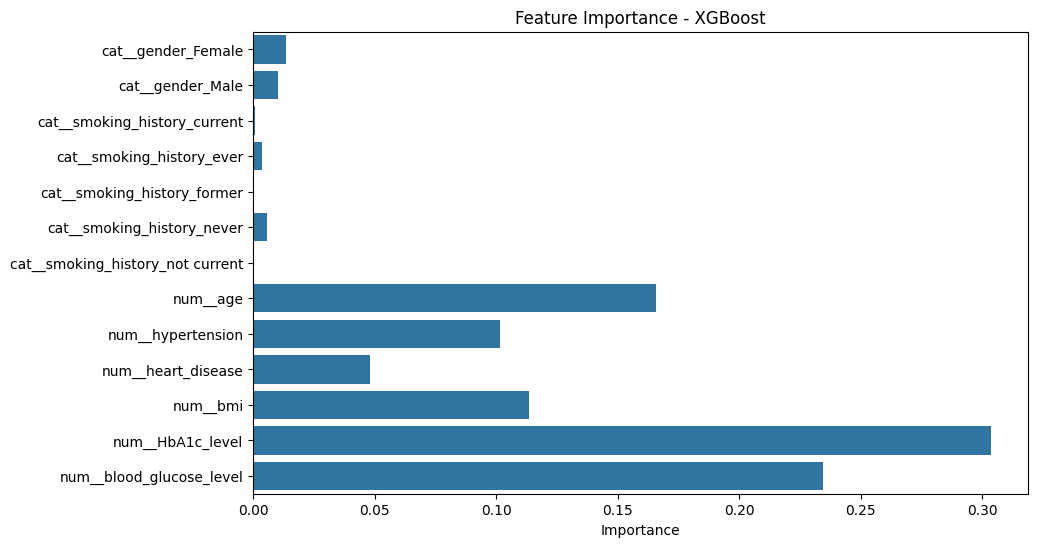

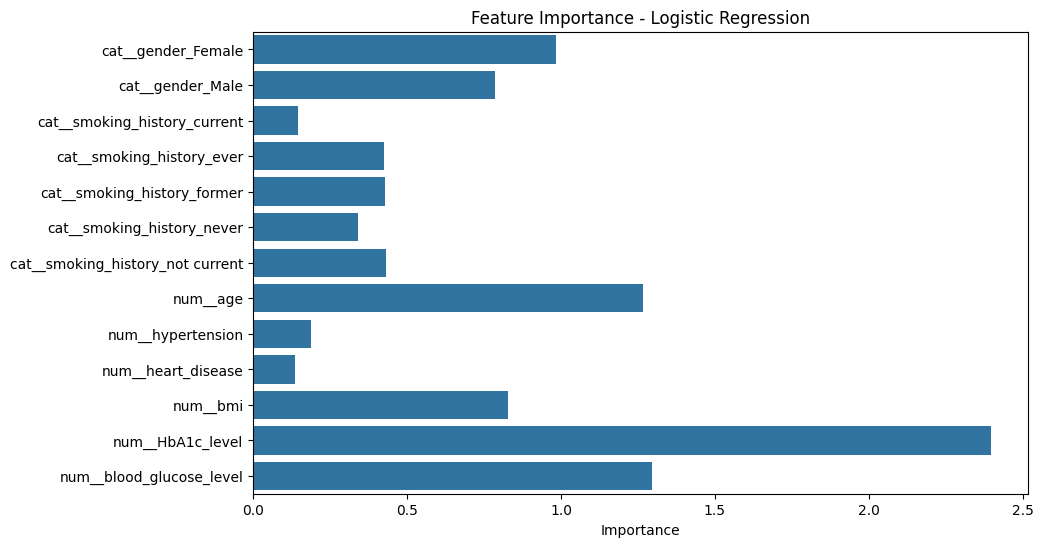

In [13]:
# for name in ["Random Forest", "XGBoost"]:
#     model = best_models[name]
#     feature_names = (model.named_steps['preprocessing']
#                      .get_feature_names_out())
#     importances = model.named_steps['classifier'].feature_importances_
    
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x=importances, y=feature_names)
#     plt.title(f"Feature Importance - {name}")
#     plt.xlabel("Importance")
#     plt.show()
#############
for name in ["Random Forest", "XGBoost", "Logistic Regression"]:
    model = best_models[name]
    feature_names = model.named_steps['preprocessing'].get_feature_names_out()
    
    # Check if the classifier has feature_importances_ or coef_
    classifier = model.named_steps['classifier']
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])  # Take absolute values of coefficients
    else:
        print(f"Feature importance is not available for {name}.")
        continue
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=feature_names)
    plt.title(f"Feature Importance - {name}")
    plt.xlabel("Importance")
    plt.show()

# Compare Models

<Figure size 800x500 with 0 Axes>

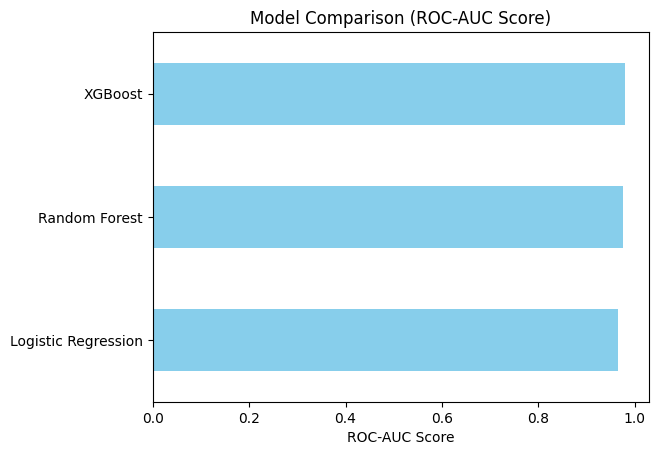

In [14]:

# --- Compare Models ---
comparison_df = pd.DataFrame.from_dict(results, orient='index', columns=['ROC-AUC Score'])
comparison_df.sort_values(by='ROC-AUC Score', ascending=True, inplace=True)
plt.figure(figsize=(8, 5))
comparison_df.plot(kind='barh', legend=False, title="Model Comparison (ROC-AUC Score)", color='skyblue')
plt.xlabel("ROC-AUC Score")
plt.show()



# Best Model

In [15]:
best_model_name = comparison_df.idxmax()['ROC-AUC Score']
print(f"\nBest Model: {best_model_name} with ROC-AUC Score: {results[best_model_name]:.4f}")


Best Model: XGBoost with ROC-AUC Score: 0.9799


In [16]:
# from category_encoders import TargetEncoder
# preprocessor = ColumnTransformer(transformers=[
#     ('cat_gender', OneHotEncoder(handle_unknown='ignore'), ['gender']),
#     ('cat_smoking', TargetEncoder(), ['smoking_history']),
#     ('num', StandardScaler(), numerical_cols)
# ])

In [17]:
#save all models by pickle
results

{'Logistic Regression': np.float64(0.9647592441994586),
 'Random Forest': np.float64(0.976035609714501),
 'XGBoost': np.float64(0.9799207659800082)}

In [18]:
#save the three models
import pickle
import os
for name, model in best_models.items():
    os.makedirs("models", exist_ok=True)
    with open(f"models/{name.replace(' ', '_').lower()}.pkl", 'wb') as f:
        pickle.dump(model, f)
        print(f"Saved {name} model to disk.")

Saved Logistic Regression model to disk.
Saved Random Forest model to disk.
Saved XGBoost model to disk.
